# Реализация функции определения сложности слова (Гареева)

Для определения сложности слова напишем функцию, которая будет принимать на вход строку-слово и возвращать значение каждого параметра сложности от 0 до 1, где 0 - очень простое слово, 1 - очень сложное, и их среднюю сложность.

Для этого напишем отдельно функции определения сложности каждого параметра, которые будут возвращать значение от 0 до 1.

In [1]:
import os
import shutil
import io
import zipfile
import requests
import string
import pandas as pd
import numpy as np
from typing import Optional, List
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
import warnings

warnings.filterwarnings('ignore')

### Приведение слова к нужному формату

Многие библиотеки, работающие со словами, и датасеты со словами, используют только определенные форматы: строчные буквы, нет лишних пробелов, нормальная форма. Нужно уметь преобразовывать любое слово к такому формату - для этого напишем функцию преобразования к читаемому виду и функцию, получающую нормальную форму слова и её часть речи.

Для приведения слова к нормальной форме будем использовать библиотеку **pymorphy2** (https://pymorphy2.readthedocs.io/en/stable/index.html), которая может привести к нормальной форме даже несуществующее слово.

In [2]:
# %pip install pymorphy2

In [3]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def transform_word(word: str) -> tuple:
    delete_symbols = set(string.punctuation) - set('-') | set('«»…')
    word = ''.join([w for w in word.replace(' ', '') if w not in delete_symbols])
    word = re.sub('[a-zA-Z]|\d', '', word)
    is_capitalized = word[0].isupper() if word else False
    return word.lower(), is_capitalized

def get_word_info(word: str) -> tuple: 
    morph_parse = morph.parse(word)[0]
    return word, morph_parse.normal_form, morph_parse.tag.POS 

Протестируем

In [4]:
print(transform_word(word='танцующая'))
print(transform_word(word='  "ЧтО-НибУ1д Ь" '))

print(get_word_info(word=transform_word(word='танцующая')[0]))
print(get_word_info(word=transform_word(word='  "ЧтО-НибУ1д Ь" ')[0]))

('танцующая', False)
('что-нибудь', True)
('танцующая', 'танцующий', 'ADJF')
('что-нибудь', 'что-нибудь', 'NPRO')


### Датасеты

Для работы с частотностью слов, скачаем открытый датасет (52138 слов) с большим количеством лемм (нормальных форм слова) с их частотностью (**Freq(ipm)**), приведем леммы к строчным буквам и оставим только нужные нам параметры (**Lemma, Freq(ipm)**), добавив параметр длины слова (**length**).

О. Н. Ляшевская, С. А. Шаров НОВЫЙ ЧАСТОТНЫЙ СЛОВАРЬ РУССКОЙ ЛЕКСИКИ (http://dict.ruslang.ru/freq.php)

In [5]:
def save_zip_csv(url: str, dirname: str, new_filename: str) -> None:
    fullname = os.path.join(dirname, new_filename)
    
    if not os.path.exists(fullname):
        r = requests.get(url)
        with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
            archive.extractall(dirname)
    return fullname

In [6]:
fullname = save_zip_csv(url='http://dict.ruslang.ru/Freq2011.zip',
                        dirname='datasets/freq',
                        new_filename='freqrnc2011.csv')

freq_df = pd.read_csv(fullname, sep='\t')[['Lemma', 'Freq(ipm)']]
freq_df['Lemma'] = freq_df['Lemma'].str.lower()
freq_df['length'] = freq_df['Lemma'].str.len()
freq_df = freq_df.drop_duplicates(subset=['Lemma'])
freq_df = freq_df.set_index('Lemma')

freq_df.info()
freq_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 51682 entries, а to ящур
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Freq(ipm)  51682 non-null  float64
 1   length     51682 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 1.2+ MB


,Freq(ipm),length
Lemma,,
пальто,48.6,6
негостеприимный,0.5,15
воркутинский,0.4,12
предпочитать,46.3,12
забавно,6.2,7


Для работы с морфемами слов, скачаем открытый датасет (103526 слов) с большим количеством лемм (нормальных форм слова) с их морфологическим разбором, приведем леммы к строчным буквам и оставим только их с нужным нам разбором слова по составу (**Lemma, analysis**), добавив количество морфем (**count_morph**). 

А.Н. Тихонов. Словообразовательный словарь русского языка в двух томах. (http://speakrus.ru/dict2/index.htm)

In [7]:
def save_zip_txt(url: str, dirname: str, new_filename: str) -> None:
    fullname = os.path.join(dirname, new_filename)
    
    if not os.path.exists(fullname):
        shutil.rmtree(dirname, ignore_errors=True)

        r = requests.get(url)
        with r, zipfile.ZipFile(io.BytesIO(r.content)) as archive:
            archive.extractall(dirname)

        for filename in os.listdir(dirname):
            if filename.endswith('.txt'):
                with open(os.path.join(dirname, filename), 'rb') as f:
                    text = f.read().decode('cp1251')
                    with open(fullname, 'wb') as ru:
                        ru.write(text.encode('utf-8'))
    return fullname

In [8]:
fullname = save_zip_txt(url='http://www.speakrus.ru/dict2/tikhonov.zip',
                        dirname='datasets/tikhonov',
                        new_filename='tikhonov.txt')
        
morph_df = pd.read_csv(fullname, sep='|', names=['Lemma', 'analysis'])
morph_df['Lemma'] = morph_df['Lemma'].str.replace('\d+', '').str.split().str[0].str.lower()
morph_df['analysis'] = morph_df['analysis'].str.replace('\d+', '').str.split(pat=',', n=1).str[0].str.split().str[0]
morph_df['count_morph'] = morph_df['analysis'].str.count(pat='/') + 1
morph_df = morph_df.drop_duplicates(subset=['Lemma'])
morph_df = morph_df.set_index('Lemma')

morph_df.info()
morph_df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Index: 101103 entries, -ка to ящурный
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   analysis     101103 non-null  object
 1   count_morph  101103 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


,analysis,count_morph
Lemma,,
нахмуренный,на/хму'р/енн/ый,4
альт,альт/,2
выпугиваться,вы/пу'г/ива/ть/ся,5
гомосексуализм,гом/о/секс/у/ал/и'зм/,7
бета-спектрометр,бе'та/-спектр/о'/метр/,5


### Фонетическая транскрипция

Напишем функцию определения сложности параметра соотношения фонетической и графической сложности. (Чем сильнее несоотношение, тем больше параметр сложности.) 

Для этого напишем функцию создания транскрипции, пренебрегая обозначениями мягкости (они не влияют на неочевидность написания) и ударениями (будем считать, что любая гласная безударная), используя известные правила русского языка из открытых источников. (https://tutrus.com/fonetika/foneticheskiy-razbor-nachalnaya-shkola) Если буква имеет нетривиальную фонетическую запись или беззвучна, будем добавлять ей очко несовпадения. 

In [9]:
vowels = set('аяоёуюыиэе')
consonants = set('бвгджзйклмнпрстфхцчшщ')
marks = set('ъь')

deaf_consonants = set('пфктшсхцчщ')
voices_consonants = set('лмнрйбвгджз')

ioted_vowels = { 
    'я' : {'one': 'а', 'two': 'йа'},
    'ё' : {'one': 'о', 'two': 'йо'},
    'ю' : {'one': 'у', 'two': 'йу'},
    'е' : {'one': 'э', 'two': 'йэ'},
}

stress_vowels = {
    'о': {'stress': 'о', 'not_stress': 'a'},
    'е': {'stress': 'э', 'not_stress': 'и'},
    'я': {'stress': 'а', 'not_stress': 'и'},
}

deaf_pairs = {
    'б': 'п',
    'в': 'ф',
    'г': 'к',
    'д': 'т',
    'ж': 'ш',
    'з': 'с'
}

simple_groups = { #abc -> ac
    'с' : {'т': set('нл')}, # стн, стл 
    'н' : {'д': set('шц'), 'т': 'г'}, # ндш, ндц, нтг
    'з' : {'д': set('нц')}, # здн, здц
    'р' : {'д': set('цч')} # рдц, рдч 
}

sh_groups = { # ab -> шb
    'ч' : set('нт') # чн, чт
}

sch_groups = { # ab -> щ
    'с' : 'ч', # сч
    'з' : 'ч', # зч
    'ж' : 'ч', # жч
}

def get_transcription(word: str) -> tuple:
    diff = [0] * len(word)
    transcription = ['!'] * len(word)
    for i in range(len(word)):
        c = word[i]
        before_c = word[i - 1] if i > 0 else None
        after_c = word[i + 1] if i < len(word) - 1 else None
        after_after_c = word[i + 2] if i < len(word) - 2 else None
        if c in vowels:
            transcription[i] = c
            diff[i] = 0
            if c in ioted_vowels:
                if i == 0 or before_c in vowels or before_c in marks:
                    transcription[i] = ioted_vowels[c]['two']
                    diff[i] = 2
                else:
                    transcription[i] = ioted_vowels[c]['one']
                    diff[i] = 1
            elif c == 'и':
                if before_c == 'ь':
                    transcription[i] = 'йи'
                    diff[i] = 2
                elif before_c in set('жшц'):
                    transcription[i] = 'ы'
                    diff[i] = 1
                else:
                    transcription[i] = 'и'
                    diff[i] = 0
            elif c in stress_vowels:
                transcription[i] = stress_vowels[c]['not_stress']
                diff[i] = 1
        elif c in consonants:
            transcription[i] = c
            diff[i] = 0
            if c in deaf_pairs:
                if i == len(word) - 1 or after_c in deaf_consonants:
                    transcription[i] = deaf_pairs[c]
                    diff[i] = 1
            if before_c and after_c and\
                before_c in simple_groups and\
                c in simple_groups[before_c] and\
                after_c in simple_groups[before_c][c]:
                transcription[i] = ''
                diff[i] = 1
            if before_c in sh_groups and c in sh_groups[before_c]:
                transcription[i - 1] = 'ш'
                diff[i - 1] = 1
            if before_c in sch_groups and c in sch_groups[before_c]:
                transcription[i - 1] = 'щ'
                diff[i - 1] = 1
                transcription[i] = ''
                diff[i] = 1
            if before_c == 'л' and c == 'н' and after_c == 'ц':
                transcription[i - 1] = ''
                diff[i - 1] = 1
            if before_c == 'в' and c == 'с' and after_c == 'т' and after_after_c == 'в':
                transcription[i - 1] = ''
                diff[i - 1] = 1
            if i == 0 and c == 'с' and after_c in voices_consonants:
                transcription[i] = 'з'
                diff[i] = 1
            if c == 'г' and after_c in deaf_consonants:
                transcription[i] = 'x'
                diff[i] = 1
            if before_c == c:
                transcription[i] = ''
                diff[i] = 1
        else:
            transcription[i] = ''
            diff[i] = 1
    if word.endswith(('ого', 'его')):
        transcription[-2] = 'в'
        diff[-2] = 1
    if word.endswith('тся'):
        transcription[-3] = 'ц'
        diff[-3] = 1
        transcription[-2] = ''
        diff[-2] = 1
    if word.endswith('ться'):
        transcription[-4] = 'ц'
        diff[-4] = 1
        transcription[-3] = ''
        diff[-3] = 1
        transcription[-2] = ''
        diff[-2] = 1
    return sum(diff), diff, transcription

Протестируем

In [10]:
print(get_transcription(word='поёт'), '[пай’от]')
print(get_transcription(word='чьи'), '[ч’й’и]')
print(get_transcription(word='лисьи'), '[лис’й’и]')
print(get_transcription(word='гриб'), '[гр’ип]')
print(get_transcription(word='солнце'), '[сОнцэ]')
print(get_transcription(word='ванна'), '[ван:а]')
print(get_transcription(word='конечно'), '[кан‘эшна]')
print(get_transcription(word='счастливый'), '[щ‘асливый‘]')
print(get_transcription(word='белого'), '[б’Элава]')
print(get_transcription(word='бриться'), '[бр’иц:а]')

(3, [0, 1, 2, 0], ['п', 'a', 'йо', 'т']) [пай’от]
(3, [0, 1, 2], ['ч', '', 'йи']) [ч’й’и]
(3, [0, 0, 0, 1, 2], ['л', 'и', 'с', '', 'йи']) [лис’й’и]
(1, [0, 0, 0, 1], ['г', 'р', 'и', 'п']) [гр’ип]
(3, [0, 1, 1, 0, 0, 1], ['с', 'a', '', 'н', 'ц', 'э']) [сОнцэ]
(1, [0, 0, 0, 1, 0], ['в', 'а', 'н', '', 'а']) [ван:а]
(4, [0, 1, 0, 1, 1, 0, 1], ['к', 'a', 'н', 'э', 'ш', 'н', 'a']) [кан‘эшна]
(3, [1, 1, 0, 0, 1, 0, 0, 0, 0, 0], ['щ', '', 'а', 'с', '', 'л', 'и', 'в', 'ы', 'й']) [щ‘асливый‘]
(4, [0, 1, 0, 1, 1, 1], ['б', 'э', 'л', 'a', 'в', 'a']) [б’Элава]
(4, [0, 0, 0, 1, 1, 1, 1], ['б', 'р', 'и', 'ц', '', '', 'а']) [бр’иц:а]


Функция получает транскрипции, которые могут расходиться с корректным результатом (например, из-за того, что мы не учитываем ударение), но достаточно хорошо определяет количество несовпадений.

На основе датасета с частотами рассмотрим сложности транскрипции слова. Нарисуем столбчатую диаграмму вероятности каждого количества несовпадений транскрипции слова (считаем количество слов каждого количества несовпадений и делим на общее количество слов) и функцию её распределения.

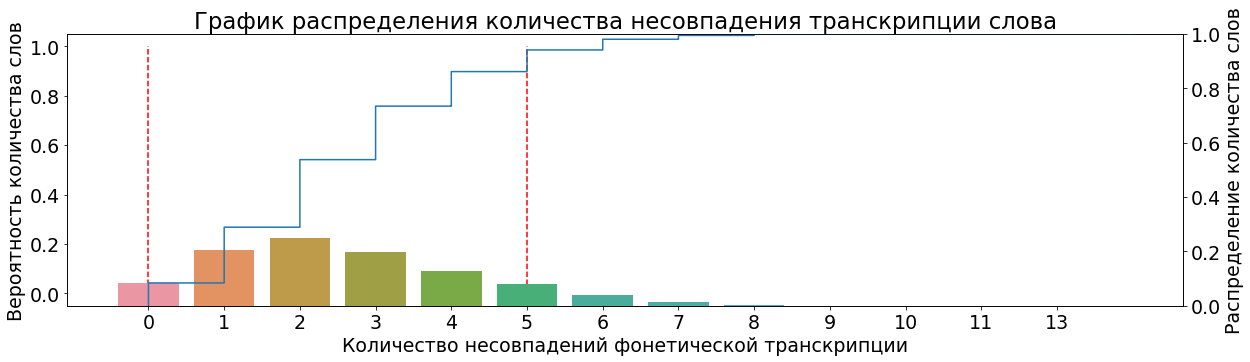

In [11]:
plt.rc('font', size=19)

fig, ax = plt.subplots(figsize=(20, 5))
ax2 = ax.twinx()

df = freq_df.index.map(lambda word: get_transcription(word)[0])
sns.barplot(x=df, y=df, estimator=lambda x: len(x) / len(df))
sns.ecdfplot(x=df)
ax.vlines(0, ymin=0, ymax=1, color='r', linestyle = '--')
ax.vlines(5, ymin=0, ymax=1, color='r', linestyle = '--')

ax.set_title('График распределения количества несовпадения транскрипции слова')
ax.set_ylabel('Вероятность количества слов')
ax2.set_ylabel('Распределение количества слов')
ax.set_xlabel('Количество несовпадений фонетической транскрипции')

plt.show()

Методом экспертной оценки заметим, что мы можем выделить среднее фонетическое несовпадение в значении 2, а слов с несовпадением больше 5 очень мало.

Нормализуем количество несовпадений от 0 до 1 по методу минимакс так, чтобы значение 0.5 соотносилось со средним значением. Для этого за минимум возьмем значение 0, за максимум 5.

На вход будем принимать любую форму слова (не будем приводить к лемме), так как окончания могут иметь сложное произношение.

In [12]:
MIN_PHONEME = 0
MAX_PHONEME = 5

def word_phoneme_param(word: str) -> float:
    diff, _, _= get_transcription(word)
    normalize_phoneme = (diff - MIN_PHONEME) / (MAX_PHONEME - MIN_PHONEME)
    return max(0, min(normalize_phoneme, 1))

Протестируем

In [13]:
print(word_phoneme_param(word='маги'))
print(word_phoneme_param(word='я'))
print(word_phoneme_param(word='поёт'))
print(word_phoneme_param(word='абсолютность'))

0
0.4
0.6
1.0


### Длина слова

Напишем функцию определения сложности параметра длины слова. (Чем длиннее слово, тем больше должен быть параметр сложности слова по длине.) Для этого сделаем преданализ данных из вышеупомянутого датасета.

Нарисуем столбчатую диаграмму вероятности каждой длины слова (считаем количество слов каждой длины и делим на общее количество слов) и функцию её распределения.

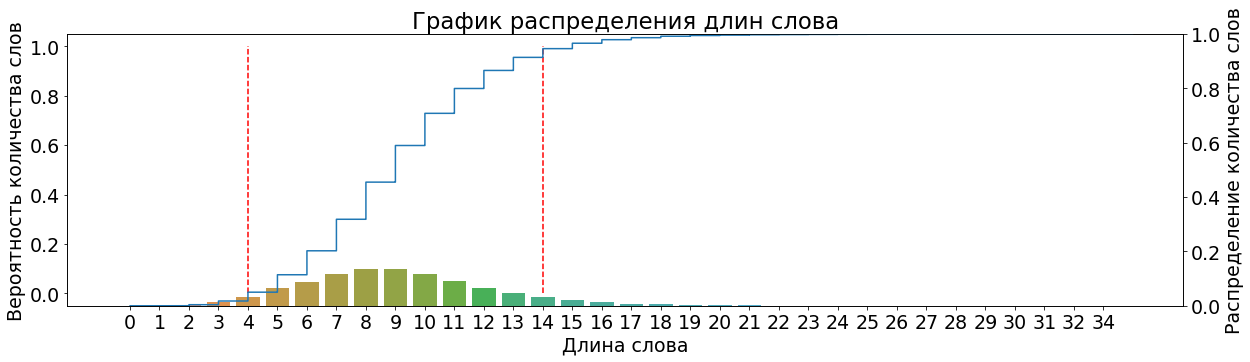

In [14]:
plt.rc('font', size=19)

fig, ax = plt.subplots(figsize=(20, 5))
ax2 = ax.twinx()

df = freq_df['length']
df = df.append(pd.Series([0]))

sns.barplot(x=df, y=df, estimator=lambda x: len(x) / len(df))
sns.ecdfplot(x=df)
ax.vlines(4, ymin=0, ymax=1, color='r', linestyle = '--')
ax.vlines(14, ymin=0, ymax=1, color='r', linestyle = '--')

ax.set_title('График распределения длин слова')
ax.set_ylabel('Вероятность количества слов')
ax2.set_ylabel('Распределение количества слов')
ax.set_xlabel('Длина слова')
plt.show()

Методом экспертной оценки заметим, что мы можем выделить среднюю длину в значении 8-9, а слов короче 4 и длиннее 14 очень мало.

Нормализуем длину от 0 до 1 по методу минимакс так, чтобы значение 0.5 соотносилось со средним значением. Для этого за минимум возьмем значение 4, за максимум 14.

На вход будем принимать любую форму слова (не будем приводить к лемме), так как слова удлиняемые сложными окончаниями, можно считать сложнее.

In [15]:
MIN_LENGTH = 4
MAX_LENGTH = 14

def word_length_param(word: str) -> float:
    normalize_length = (len(word) - MIN_LENGTH) / (MAX_LENGTH - MIN_LENGTH)
    return max(0, min(normalize_length, 1))

Протестируем

In [16]:
print(word_length_param(word='a'))
print(word_length_param(word='aaaaa'))
print(word_length_param(word='aaaaaaaaa'))
print(word_length_param(word='aaaaaaaaaaaaaa'))
print(word_length_param(word='aaaaaaaaaaaaaaaaaaaa'))

0
0.1
0.5
1.0
1


### Частотность слова

Напишем функцию определения сложности параметра частотности слова. (Чем больше частота использования слово, тем меньше должен быть параметр сложности слова по частотности.) Для этого сделаем преданализ данных из вышеупомянутого датасета.

Найдем минимальную и максимальную логарифмическую частотность слов.

In [17]:
print('Минимальная частотность (log1p):', np.log1p(freq_df['Freq(ipm)'].min()))
print('Максимальная частотность (log1p):', np.log1p(freq_df['Freq(ipm)'].max()))

Минимальная частотность (log1p): 0.33647223662121295
Максимальная частотность (log1p): 10.485781381620873


Нарисуем функции плотности и распределения значения логарифма от частотности слов в различных промежутках, выводя примеры слов с минимальной и максимальной частотностью, чтобы определить лучшие границы для нормализации длины от 0 до 1 по методу минимакс.

In [18]:
def show_freq_distplot(FROM, TO):
    plt.rc('font', size=13)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax2 = ax.twinx()
    
    df = np.log1p(freq_df['Freq(ipm)'])
    sns.distplot(x=df, hist=False, kde=True)
    sns.ecdfplot(x=df)
    ax.vlines(1, ymin=0, ymax=1, color='r', linestyle = '--')
    ax.vlines(4, ymin=0, ymax=1, color='r', linestyle = '--')

    ax.set_title('Распределение частотности слов (log1p) от ' + str(FROM) + ' до ' + str(TO))
    ax.set_ylabel('Плотность (log1p)')
    ax2.set_ylabel('Распределение\n частотности слов (log1p)')
    ax.set_xlabel('Частотность слова (log1p)')

    plt.xlim(FROM, TO)
    plt.show()
    
    condition = ((FROM <= np.log1p(freq_df['Freq(ipm)'])) & (np.log1p(freq_df['Freq(ipm)']) <= TO))
    sorted_freq_df = freq_df[condition].rename_axis('Lemma').sort_values(by=['Freq(ipm)', 'Lemma'])
    print('Слова с минимальной частотностью:\n', sorted_freq_df.head(5).index.values)
    print('Слова с максимальной частотностью:\n', sorted_freq_df.tail(5).index.values)

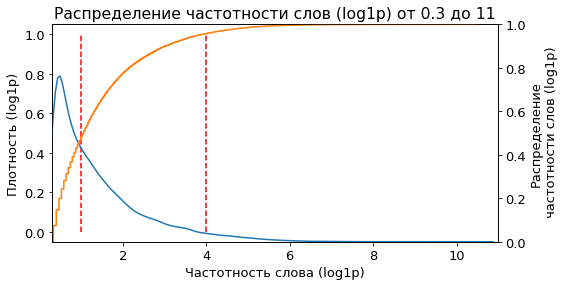

Слова с минимальной частотностью:
 ['абонементный' 'абсолютность' 'абсорбент' 'абстрагировать' 'абсцесс']
Слова с максимальной частотностью:
 ['быть' 'я' 'не' 'в' 'и']


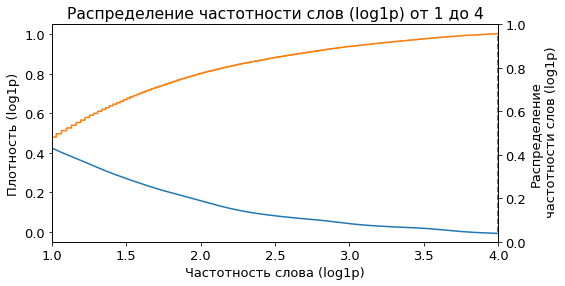

Слова с минимальной частотностью:
 ['абонемент' 'аввакум' 'авиатор' 'автопортрет' 'автопром']
Слова с максимальной частотностью:
 ['набор' 'производитель' 'пыль' 'философия' 'япония']


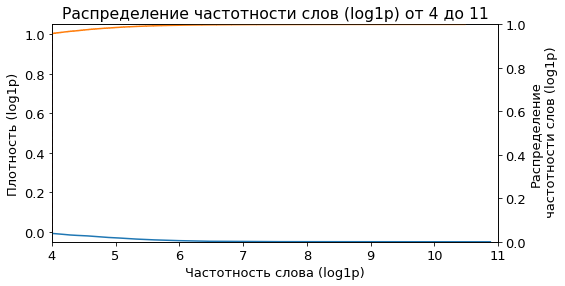

Слова с минимальной частотностью:
 ['девять' 'объяснение' 'сдать' 'положительный' 'терпеть']
Слова с максимальной частотностью:
 ['быть' 'я' 'не' 'в' 'и']


In [19]:
show_freq_distplot(FROM=0.3, TO=11)
show_freq_distplot(FROM=1, TO=4)
show_freq_distplot(FROM=4, TO=11)

Методом экспертной оценки заметим, что оптимально взять за минимум значение логарифма 1, за максимум 4.

На вход будем принимать нормальную форму слова (будем приводить к лемме), так как слова берутся из словаря с леммами. Если слова нет в словаре, то не будем учитывать данный параметр.

In [20]:
MIN_FREQ_LOG = 1
MAX_FREQ_LOG = 4

def word_freq_param(lemma: str) -> Optional[float]:
    if lemma not in freq_df.index:
        return None
    found_lemma = freq_df.loc[lemma]
    freq = np.log1p(found_lemma['Freq(ipm)'].item())
    normalize_freq = (freq - MIN_FREQ_LOG) / (MAX_FREQ_LOG - MIN_FREQ_LOG)
    return 1 - max(0, min(normalize_freq, 1))

Протестируем

In [21]:
print(word_freq_param(lemma='None'))
print(word_freq_param(lemma='я'))
print(word_freq_param(lemma='актриса'))
print(word_freq_param(lemma='убирать'))
print(word_freq_param(lemma='попугай'))
print(word_freq_param(lemma='прогуливать'))
print(word_freq_param(lemma='кулич'))

None
0
0.09223970638957713
0.31849252075885903
0.5340349090672099
0.96712923711063
1


### Часть речи слова

Будем определять семантическую сложность через частеречную принадлежность. Для этого будем использовать библиотеку pymorphy2 (https://pymorphy2.readthedocs.io/en/stable/index.html), которая может попытаться определить частеречную принадлежность даже несуществующего слова.(https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html)

Разобьем слова на группы по семантической сложности (чем сложнее смысл, тем больше должен быть параметр сложности слова по части речи):
- мало несущие в себе смысл (0): 
    - числительное (NUMR)
    - наречие (ADVB)
    - местоимение-существительное (NPRO)
    - предикатив (PRED)
    - предлог (PREP)
    - союз (CONJ)
    - частица (PRCL)
    - междометие (INTJ)
- изначально созданы для обозначения реальных и наглядных вещей (0.5): 
    - имя существительное (NOUN)
    - имя прилагательное (полное - ADJF, краткое - ADJS)
    - компаратив (COMP)
    - глагол (личная форма - VERB, инфинитив - INFN)
- имеющие сложные смысловые значения (1):
    - причастие (полное - PRTF, краткое - PRTS)
    - деепричастие (GRND)
    
На вход будем принимать уже часть речи.

In [22]:
simple_POS = {'NUMR', 'ADVB', 'NPRO', 'PRED', 'PREP', 'CONJ', 'PRCL', 'INTJ'}
medium_POS = {'NOUN', 'ADJF', 'ADJS', 'COMP', 'VERB', 'INFN'}
difficult_POS = {'PRTF', 'PRTS', 'GRND'}

def word_POS_param(POS: str) -> Optional[float]:
    if POS in simple_POS:
        return 0
    if POS in medium_POS:
        return 0.5
    if POS in difficult_POS:
        return 1
    return None

Протестируем

In [23]:
print(word_POS_param(POS=morph.parse('None')[0].tag.POS))
print(word_POS_param(POS=morph.parse('я')[0].tag.POS))
print(word_POS_param(POS=morph.parse('иду')[0].tag.POS))
print(word_POS_param(POS=morph.parse('пританцовывая')[0].tag.POS))

None
0
0.5
1


### Морфемный разбор слова

Напишем функцию определения сложности параметра морфем слова. (Чем больше в слове морфем, тем больше должен быть параметр сложности слова по морфемам.) Для этого сделаем преданализ данных из вышеупомянутого датасета.

Нарисуем столбчатую диаграмму вероятности каждого количества морфем слова (считаем количество слов каждого количества морфем и делим на общее количество слов) и функцию её распределения.

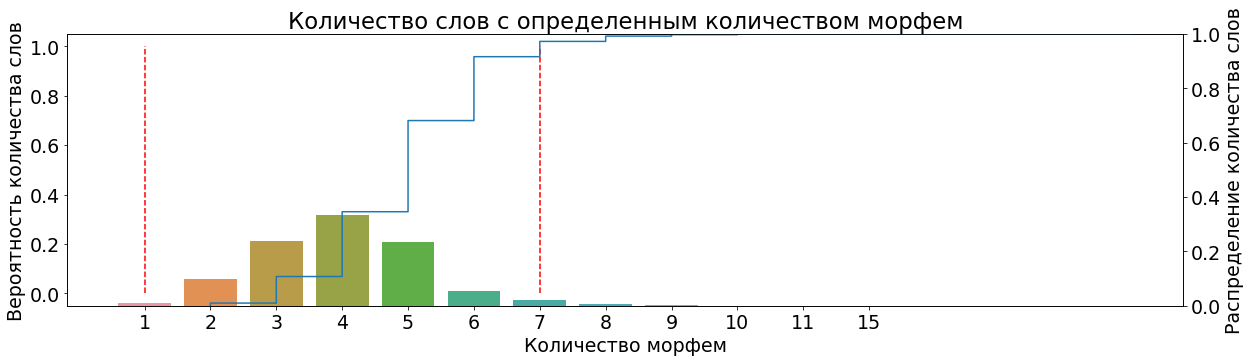

In [24]:
plt.rc('font', size=19)

fig, ax = plt.subplots(figsize=(20, 5))
ax2 = ax.twinx()

df = morph_df['count_morph']
sns.barplot(x=df, y=df, estimator=lambda x: len(x) / len(df))
sns.ecdfplot(x=df)
ax.vlines(1 - 1, ymin=0, ymax=1, color='r', linestyle = '--')
ax.vlines(7 - 1, ymin=0, ymax=1, color='r', linestyle = '--')

ax.set_title('Количество слов c определенным количеством морфем')
ax.set_ylabel('Вероятность количества слов')
ax2.set_ylabel('Распределение количества слов')
ax.set_xlabel('Количество морфем')
plt.show()

Методом экспертной оценки заметим, что мы можем выделить среднее количество морфем в значении 4, а морфем больше 7 очень мало.

Нормализуем количество морфем от 0 до 1 по методу минимакс так, чтобы значение 0.5 соотносилось со средним значением. Для этого за минимум возьмем значение 1, за максимум 7.

На вход будем принимать нормальную форму слова (будем приводить к лемме), так как слова берутся из словаря с леммами. Если слова нет в словаре, то не будем учитывать данный параметр.

In [25]:
MIN_MORPH = 1
MAX_MORPH = 7

def word_morph_param(lemma: str) -> Optional[float]:
    if lemma not in morph_df.index:
        return None
    found_lemma = morph_df.loc[lemma]
    count_morph = found_lemma['count_morph'].item()
    normalize_morph = (count_morph - MIN_MORPH) / (MAX_MORPH - MIN_MORPH)
    return max(0, min(normalize_morph, 1))

Протестируем

In [26]:
print(word_morph_param(lemma='None'))
print(word_morph_param(lemma='я'))
print(word_morph_param(lemma='стол'))
print(word_morph_param(lemma='припрыгивать'))
print(word_morph_param(lemma='пританцовывать'))
print(word_morph_param(lemma='авиационноспортивный'))

None
0
0.16666666666666666
0.5
0.6666666666666666
1.0


### Финальная функция определения сложности слова

Объединим все параметры сложности слова и возьмем среднее значение от их результата - это и будет общая сложность слова от 0 до 1. Если параметр не удалось оценить, будем его игнорировать.

Было решено не использовать параметр части речи слова, так как разбиение на 0, 0.5 и 1, где 0.5 принадлежит самым распространённым частям речи - глаголам, существительным и прилагательных, получается очень грубым и слишком "уравнивает" результаты.

In [27]:
def word_difficulty(word: str) -> dict:
    word, lemma, POS = get_word_info(word)
    params = {'word_phoneme_param': word_phoneme_param(word),
              'word_length_param': word_length_param(word),
              'word_freq_param': word_freq_param(lemma),
              #'word_POS_param': word_POS_param(POS),
              'word_morph_param': word_morph_param(lemma)}
    difficulty = np.mean([param for param in params.values() if param is not None])
    return {'lemma': lemma, 'difficulty': difficulty, 'params': params}

Протестируем

In [28]:
text_df = pd.DataFrame(columns=['lemma', 'difficulty'])
for word in ['я', 'стол', 'припрыгивала', 'пританцовывать', 'авиационноспортивный', 'знакочередующийся']:
    difficulty = word_difficulty(word)
    info = {'lemma': difficulty['lemma'],
            'difficulty': difficulty['difficulty']}
    info.update(difficulty['params'])
    row = pd.Series(info, name=word)
    text_df = text_df.append(row)
text_df

,lemma,difficulty,word_freq_param,word_length_param,word_morph_param,word_phoneme_param
я,я,0.100000,0.0,0.0,0.0,0.4
стол,стол,0.091667,0.0,0.0,0.166667,0.2
припрыгивала,припрыгивать,0.433333,None,0.8,0.5,0.0
пританцовывать,пританцовывать,0.755716,0.956199,1.0,0.666667,0.4
авиационноспортивный,авиационноспортивный,1.000000,None,1.0,1.0,1.0
знакочередующийся,знакочередоваться,1.000000,None,1.0,None,1.0


### Проверка работы функции

Напишем функции для создания датасета сложности из текстового документа со словами и визуализации плотности распределения их сложности.

In [29]:
def distplot_text_df(text_dfs: List[pd.DataFrame], labels: List[str]=[], FROM: int=0, TO: int=1) -> None:
    plt.rc('font', size=13)
    
    fig, ax = plt.subplots(figsize=(8, 4))
    for text_df in text_dfs:
        sns.distplot(x=text_df['difficulty'], label='1')

    ax.set_title('Сложность слова от ' + str(FROM) + ' до ' + str(TO))
    ax.set_ylabel('Плотность распределения')
    ax.set_xlabel('Сложность слова')

    plt.xlim(FROM, TO)
    plt.legend(labels=labels)
    plt.show()

def analyze_text(filepath: str, stop=None, unique=True, show_plot=True) -> pd.DataFrame:
    text_df = pd.DataFrame(columns=['lemma', 'difficulty'])
    with open(filepath, 'rb') as f:
        for i, word in enumerate(tqdm(f.read().decode('utf-8').split())):
            word = transform_word(word)[0]
            if word and (not unique or word not in text_df.index):
                difficulty = word_difficulty(word)
                info = {'lemma': difficulty['lemma'],
                        'difficulty': difficulty['difficulty']}
                info.update(difficulty['params'])
                row = pd.Series(info, name=word)
                text_df = text_df.append(row)
            if stop and stop <= i:
                break
    if show_plot:
        distplot_text_df([text_df], labels=[os.path.basename(filepath)])
    return text_df

Возьмем небольшой текст, чтобы мы могли протестировать сложность слов. Например, отрывок из 'Алисы в стране чудес' Льюиса Кэрролла.

In [30]:
# alice_in_wonderland_fullname = save_zip_txt(url='https://royallib.com/get/txt/keroll_lyuis/alisa_v_strane_chudes.zip',
#                                      dirname='datasets/texts/alice_in_wonderland/',
#                                      new_filename='alice_in_wonderland.txt')

  3%|██▋                                                                         | 1000/28613 [00:08<03:55, 117.18it/s]


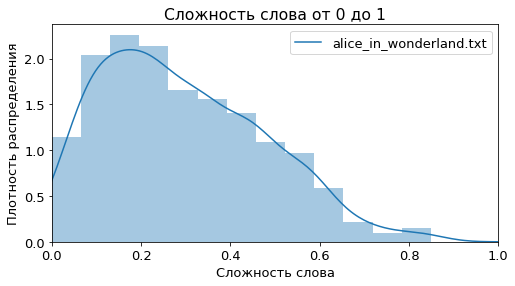

,lemma,difficulty,word_freq_param,word_length_param,word_morph_param,word_phoneme_param
word,,,,,,
а,а,0.000000,0,0.0,None,0.0
бы,бы,0.000000,0,0.0,0,0.0
вы,вы,0.000000,0,0.0,None,0.0
да,да,0.000000,0,0.0,None,0.0
за,за,0.000000,0,0.0,0,0.0
...,...,...,...,...,...,...
увеличительным,увеличительный,0.816667,1,1.0,0.666667,0.6
бессменно,бессменно,0.833333,1,0.5,None,1.0
оксфордском,оксфордский,0.833333,1,0.7,None,0.8


In [31]:
# text_df = analyze_text(filepath=alice_in_wonderland_fullname, stop=1000)
# text_df.rename_axis('word').sort_values(by=['difficulty', 'word'])

Рассмотрим плотность распределения сложности слов на основе списка слов разных уровней знания русского языка для иностранцев. Возьмем самый простой список слов - a1 и один из самых сложных - c1. (http://www.tolstyslovar.com/ru/a1)

Cохраним данные в формате .txt, распарсив страницы со списками.

In [32]:
def save_words(level:str):
    dirname = 'datasets/word_levels'
    fullname = os.path.join(dirname, str(level) + '.txt')
    
    if not os.path.exists(fullname):
        html = requests.get(os.path.join('http://www.tolstyslovar.com/ru', level)).content
        soup = BeautifulSoup(html, 'html.parser')

        word_list = []
        for word in soup.findAll(attrs={'class': 'word'}):
            word_list.append(word.text)

        os.makedirs(dirname, exist_ok=True)
        with open(fullname, 'wb') as ru:
            ru.write(' '.join(word_list).encode('utf-8'))
    return fullname

a1_level_path = save_words(level='a1')
c1_level_path = save_words(level='c1')

Найдем сложности слов каждого списка и сравним их плотности распределения.

100%|██████████████████████████████████████████████████████████████████████████████| 1463/1463 [00:15<00:00, 94.22it/s]


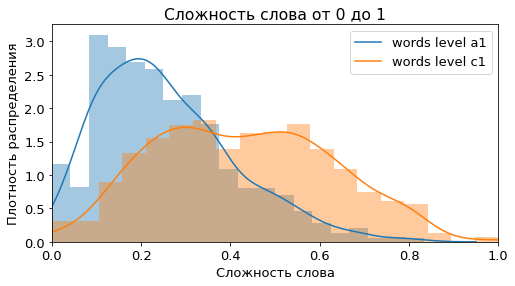

In [33]:
# a1_text_df = analyze_text(filepath=a1_level_path, show_plot=False)
# c1_text_df = analyze_text(filepath=c1_level_path, show_plot=False)
# distplot_text_df([a1_text_df, c1_text_df], labels=['words level a1', 'words level c1'])

На основе графиком видно, что наша функция определения сложности слова работает корректно. Действительно слова для начального уровня русского языка в основном простые, а слова высокого уровня - сложные.